## Example of 2D frequency-domain full waveform inversion on a horizontal reflector model with a constant density model

In this example, we will show how to use PySIT to conduct a 2D frequency-domain FWI on a horizontal reflector model with a constant density. The corresponding .py file can be found in ``/Demo/InversionHorizontalReflector2D_FrequencyDomain_ConstantDensity.py``

In [2]:
%matplotlib inline

Import necessary modules:

In [3]:
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
import math
import os
from shutil import copy2
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
import scipy.io as sio

from pysit import *
from pysit.gallery import horizontal_reflector
from pysit.util.io import *
from pysit.util.compute_tools import *

from pysit.util.parallel import *

### Define the physical domain, computational mesh and velocity models ###

1. Define perfectly matched layer(PML) boundaries in x and z directions with width of ``0.1 km`` and PML coefficient of ``1000`` by

    ``pmlx = PML(0.1, 1000)``

    ``pmlz = PML(0.1, 1000)``
    

    For more information about the PML object, we refer users to check ``/pysit/core/domain.py`` by

2. Define a 2D rectangular domain with the width of ``2 km`` and depth of ``1 km``. 
    
    ``x_config = (0.0, 2.0, pmlx, pmlx)`` (The physical domain of x direction starts at 0.0 km and ends at 2.0 km.)
    
    ``z_config = (0.0, 1.0, pmlz, pmlz)`` (The physical domain of z direction starts at 0.0 km and ends at 1.0 km.)
    
    ``d = RectangularDomain(x_config, z_config)``
    
    For more information about the RectangularDomain, we refer users to check ``/pysit/core/domain.py``.

3. Define the computational Cartesian mesh with ``201`` grids in ``x`` direction and ``101`` grids in ``z`` direction by
    
    ``m = CartesianMesh(d, 201, 101)`` (The computational mesh ``m`` meets the physical domain ``d``)
    
    For more information about the CartesianMesh object, we refer users to check ``/pysit/core/mesh.py``.
    
4. Generate the true velocity model and initial model for a Horizontal reflector model by

    ``C, C0, m, d = horizontal_reflector(m)``
    
    The output ``C`` is the true velocity model and ``C0`` is the initial model.
    
    For more information about the horizontal_reflecotr object, we refer users to check ``/pysit/gallery/horizontal_reflector.py``.
    


Text(0, 0.5, 'Z [km]')

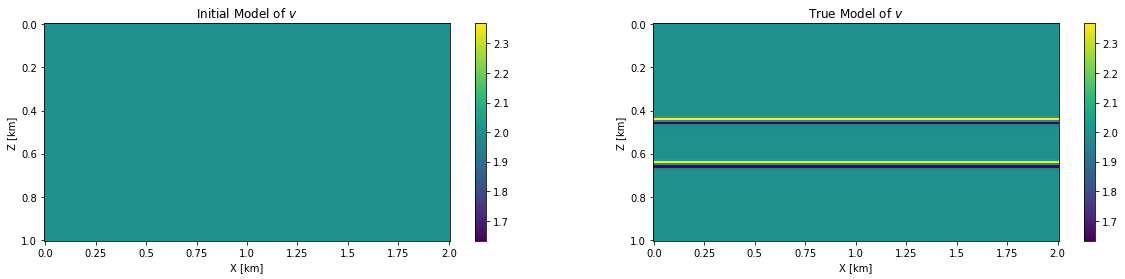

In [4]:
    pmlx = PML(0.1, 1000)
    pmlz = PML(0.1, 1000)

    x_config = (0.0, 2.0, pmlx, pmlx)
    z_config = (0.0, 1.0, pmlz, pmlz)

    d = RectangularDomain(x_config, z_config)

    m = CartesianMesh(d, 201, 101)
    
    C, C0, m, d = horizontal_reflector(m)
    
    clim = C.min(),C.max()
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    vis.plot(C0, m, clim=clim)
    plt.title(r'Initial Model of $v$')
    plt.colorbar()
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.subplot(1,2,2)
    vis.plot(C, m, clim=clim)
    plt.title(r"True Model of $v$")
    plt.colorbar()
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')

### Set up shots
1. Set up the shots object by:

    ``shots = equispaced_acquisition(m, RickerWavelet(10.0), sources=Nshots, source_depth=zpos,source_kwargs={},receivers='max',receiver_depth=zpos,receiver_kwargs={})``

    ``equispaced_acquisition`` - create a shots object with equially spaced acquisition

    ``m`` - computational mesh

    ``RickerWavelet(10.0)`` - a Ricker wavelet centered at ``10 Hz``

    ``sources`` - number of sources

    ``source_depth`` - the depth of sources

    ``receivers`` - number of receivers, if set to be ``max``, then the number of receivers equals to the number of grids in x direction.

    ``receiver_depth`` - the depth of receivers
    
    For more information about the ``equispaced_acquisition`` object, we refer the users to check ``/pysit/core/acquisition.py``. 
    

In [5]:
# Set up shots
    zmin = d.z.lbound
    zmax = d.z.rbound
    zpos = zmin + (1./10.)*zmax

    Nshots = 3

    shots = equispaced_acquisition(m,
                                   RickerWavelet(10.0),
                                   sources=Nshots,
                                   source_depth=zpos,
                                   source_kwargs={},
                                   receivers='max',
                                   receiver_depth=zpos,
                                   receiver_kwargs={}
                                   )
    
    shots_freq = copy.deepcopy(shots)


/math/home/fangzl/.local/lib/python3.6/site-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.indices) != 1 or np.rank(self.indptr) != 1:
/math/home/fangzl/.local/lib/python3.6/site-packages/scipy/sparse/construct.py:502: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(blocks) != 2:
/math/home/fangzl/.local/lib/python3.6/site-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:


<class 'float'>
3.0


### Define the wave-equation solver and the computational model object, and generate frequency-domain data 

1. In this example, we use the time-domain constant density acoustic wave as our target wave equation. We set up our wave equation solver by:

    ``solver =ConstantDensityHelmholtz(m, spatial_accuracy_order=4)``
                                     
    ``m`` - the computational mesh

    ``spatial_accuracy_order`` - the spatial accuray order for the numerical solver. Users can select one of the four values ``2, 4, 6, 8``. 

    For more information about the ``ConstantDensityHelmholtz`` object, we refer the users to check ``/pysit/solvers/wave_factory.py``
    
2. Create the velocity model object for the wave-quation solver by:

    ``base_model = solver.ModelParameters(m,{'C': C})``
    
    The model object ``base_model`` contains the information of the computational mesh and the velocity model ``C``.
    
3. Generate the frequency-domain data by:

    ``generate_seismic_data(shots, solver, base_model)``
    
    The generated data are stored in the object ``shots``. In order to check the data of the $i^{\text{th}}$ shot, you may need to use the command:
    
    ``data = shots[i].receivers.data_dft``
    
    For more information about the ``generate_seismic_data`` function, we refer the users to check ``/pysit/modeling/data_modeling.py``.

In [8]:
    solver = ConstantDensityHelmholtz(m,
                                      spatial_accuracy_order=4)
    
    base_model = solver.ModelParameters(m,{'C': C})
    
    frequencies = [2.0,3.0]
    
    generate_seismic_data(shots, solver, base_model, frequencies=frequencies)
    
    data = shots[0].receivers.data_dft
    

/math/home/fangzl/.local/lib/python3.6/site-packages/pyamg/gallery/stencil.py:116: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
/math/home/fangzl/.local/lib/python3.6/site-packages/pyamg/gallery/stencil.py:112: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diag[s] = 0
/math/home/fangzl/.local/lib/python3.6/site-packages/scipy/sparse/sputils.py:141: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(M) == 0 and

Text(0.5, 1.0, 'Imaginary part of data at f = 3.0Hz')

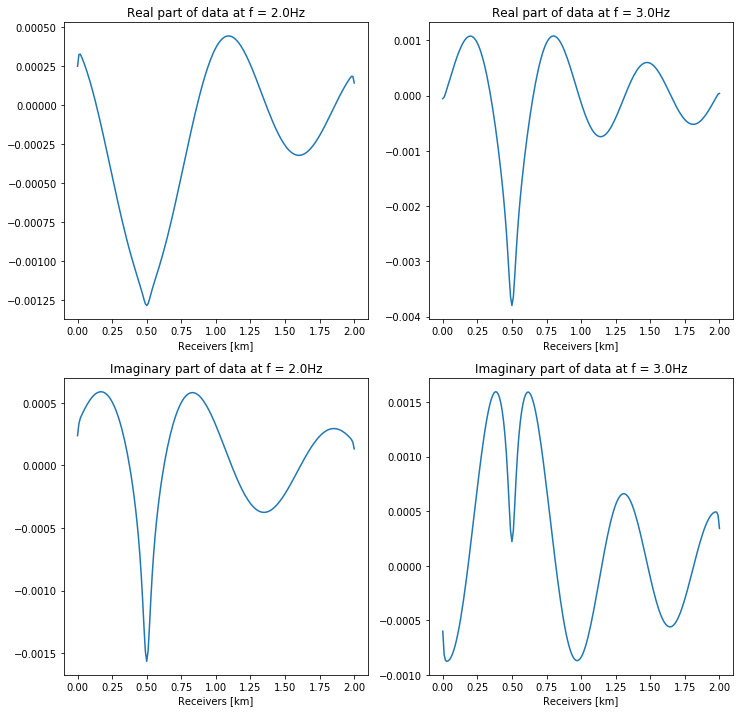

In [9]:
    xrec = np.linspace(0.0,2.0,201)
    data1 = shots[0].receivers.data_dft[2.0]
    data2 = shots[0].receivers.data_dft[3.0]
    plt.figure(figsize=(12,12))
    plt.subplot(2,2,1)
    plt.plot(xrec, np.real(data1.flatten()))
    plt.xlabel('Receivers [km]')
    plt.title('Real part of data at f = 2.0Hz')
    plt.subplot(2,2,2)
    plt.plot(xrec, np.real(data2.flatten()))
    plt.xlabel('Receivers [km]')
    plt.title('Real part of data at f = 3.0Hz')

    plt.subplot(2,2,3)
    plt.plot(xrec, np.imag(data1.flatten()))
    plt.xlabel('Receivers [km]')
    plt.title('Imaginary part of data at f = 2.0Hz')
    plt.subplot(2,2,4)
    plt.plot(xrec, np.imag(data2.flatten()))
    plt.xlabel('Receivers [km]')
    plt.title('Imaginary part of data at f = 3.0Hz')
    
    

### Inversion 

After the data generation, we will show how to set up the inversion. 

1. **Set up the objective function object.**

 The first thing for the inversion is to set up the objective function. Different from the time-domain inversion, we only provide the least-squares objective function for the frequency-domain inversion. To generate the objective function object, we can use the following command:
 
 ``objective = FrequencyLeastSquares(solver)``.
 
 
2. **Define the parallel wrapper.**

    PySIT provides the feature to compute different shots in parallel. In oreder to activate this feature, we should define a parallel wrapper. We can define the parallel wrapper by the following command:
    
    ``pwrap = ParallelWrapShot()``.
    
    For more information about the parallel wrapper, we recommend users to check the file ``/pysit/util/parallel.py``.
    
    
Now, let us generate the objective function object.

In [10]:
    pwrap = ParallelWrapShot()
    objective = FrequencyLeastSquares(solver)

3. **Define the optimization object.**

    After generating the objective function object, the next step is to generate the optimziation object. PySIT provides the following optimization algorithms: 

    <1>. projected gradient descent method, 
    
    <2>. projected quasi newton method, 
    
    <3>. Gauss-Newton method. 
    
    We can use the following command to generate the optimization object corresponding to the above algorithms. 
    
    [1]. Projected gradient descent method:
    
    ``invalg = PQN(objective, proj_op=Proj_Op)``,
    
    where the input argument ``proj_op`` is the projection operator that we decide to use in the inversion. It is an optional input argument. By default, we set ``proj_op=None``, which means we do not use any projection operator and the resulting algorithm is the basic gradient descent method. We will introduce how to generate a projcetion operator in the next cell.
    
    [2]. Projected quasi newton method:
    
    ``invalg = PQN(objective, proj_op=Proj_Op, memory_length=10)``,
    
    where the additional input argument ``memory_length`` denotes the number of previous iterations stored in the memory for l-BFGS method. Same as the projected gradient descent method, the default setting of ``proj_op`` is ``proj_op=None``.
    
    [3]. Gauss-Newton method:
    
    ``invalg = GaussNewton(objective, krylov_maxiter=50)``,
    
    where the additional input argument ``krylov_maxiter`` defines the maximal numbal of the krylov iterations used to solve the linearized problem.
    
    For More information about the optimization methods, we recommend users to check the directory ``/pysit/optimization``.
   
5. **Define the projection operator.**

    In the current version of PySIT, we provide two projection operators – ``BoxConstraintPrj`` and ``WaterVelocityPrj``. To generate the two operator, users can use the following commands:
    
    [1] Box Constraint projection:
        
    ``Proj_op1 = BoxConstraintPrj(bound)``, 
    
    where 
    
    ``bound = (v_min, v_max)`` denotes the lower and upper bound of the velocity.
    
    [2] Water Velocity Projection:
    
    ``Proj_op2 = WaterVelocityPrj(ModelSize, NumberofWaterLayer=10, WaterVel=1.5)``,
    
    where 
    
    ``ModelsSize = [nx, nz]`` denotes the size of the model,
    
    ``NumberofWaterLayer`` denotes the number of the water layer,
    
    ``WaterVel`` denotes the velocity of water.
    
    We also provide the feature to combine two projection operators. Users can achieve this by the following command:
    
    ``Proj_joint = JointPrj(Proj_op1, Proj_op2)``.
    
    For more information about the projection operator, we recommend users to check the file ``/pysit/optimization/projection.py``.
    
6. **Define the frequency bands and iterations.**

    For frequency-domain FWI, PySIT provides the feature of conducting frequency sweeping. To achive this objective, we need to define a loop_configuration which indicates the different frequency bands to be used and the number of iteration to be used for each frequency band. For example, we can use the following command to define a loop_configuration:
    
    ``loop_configuration = [(5, {'frequencies': [2.0]}), (5, {'frequencies': [3.0]})]``.
    
    This loop_congifuration indicates that we will first use the data at frequency of 2.0 Hz to conduct the inversion with 5 iterations, and then use the data at frequency of 3.0 Hz to conduct another 5 iterations.
    
    
    
7. **Set up status_configuration.**

    Please check the following python cell to check the setting of the status_configuration.

8. **Set up the line search type**.

    We recommend to use the backtrack line search by the following command: 
    
    ``line_search = 'backtrack'``.
    
9. **Set up the initial model**.

    We can set up the initial model by:
    
    ``initial_value = solver.ModelParameters(m,{'C': C0})``.

9. **Run the inversion**.

    After setting up all the necessary and optional arguments, we can conduct the inversion by:
    
    ``result = invalg(shots, initial_value, loop_configuration, verbose=True, status_configuration=status_configuration, write=False)``
                    
    where, the argument ``write`` denotes whether the user wants to write the model of each iteration to the disk.
    
    
Now, let us use PQN as an example.

In [ ]:
    bound = [1.5, 3.0]
    Proj_Op1 = BoxConstraintPrj(bound)
    invalg = PQN(objective, proj_op=Proj_Op1, memory_length=10)
    
    loop_configuration = [(5, {'frequencies': [2.0]}), (5, {'frequencies': [3.0]})]
    status_configuration = {'value_frequency'           : 1,
                            'residual_frequency'        : 1,
                            'residual_length_frequency' : 1,
                            'objective_frequency'       : 1,
                            'step_frequency'            : 1,
                            'step_length_frequency'     : 1,
                            'gradient_frequency'        : 1,
                            'gradient_length_frequency' : 1,
                            'run_time_frequency'        : 1,
                            'alpha_frequency'           : 1,
                            }
    
    initial_value = solver.ModelParameters(m,{'C': C0})
    line_search = 'backtrack'
    
    result = invalg(shots, initial_value, loop_configuration,
                    line_search=line_search,
                    status_configuration=status_configuration, verbose=True, write=False)
    

Iteration 0
  gradnorm 0.0005854718332864687
  objective 2.186089514951768e-09
  residual 6.612245480851068e-05
  Starting:  1.0 2.186089514951768e-09
  Pass 1: a:1.0; 9.876027870760634e-10 ?<= 2.1844211359409944e-09
  alpha 1.0
  run time 156.07638311386108s
Iteration 1
  gradnorm 0.0002490245110903566
  objective 9.876027870760634e-10
  residual 4.444328491630796e-05
  Starting:  1.0 9.876027870760634e-10
  Pass 1: a:1.0; 6.28414156947064e-10 ?<= 9.869842869943312e-10
  alpha 1.0
  run time 319.20535683631897s
Iteration 2


### Check result

We can check the history of the objective values by the following command:

``obj_vals = np.array([v for k,v in list(invalg.objective_history.items())])``.

We can check the final velocity model by the following command:

``v_final = result.C``.
   

Now, let us check the final results.

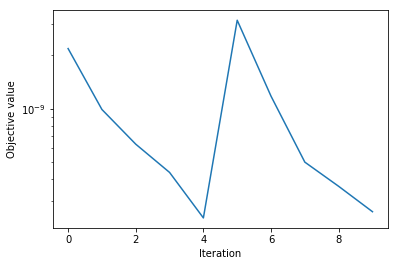

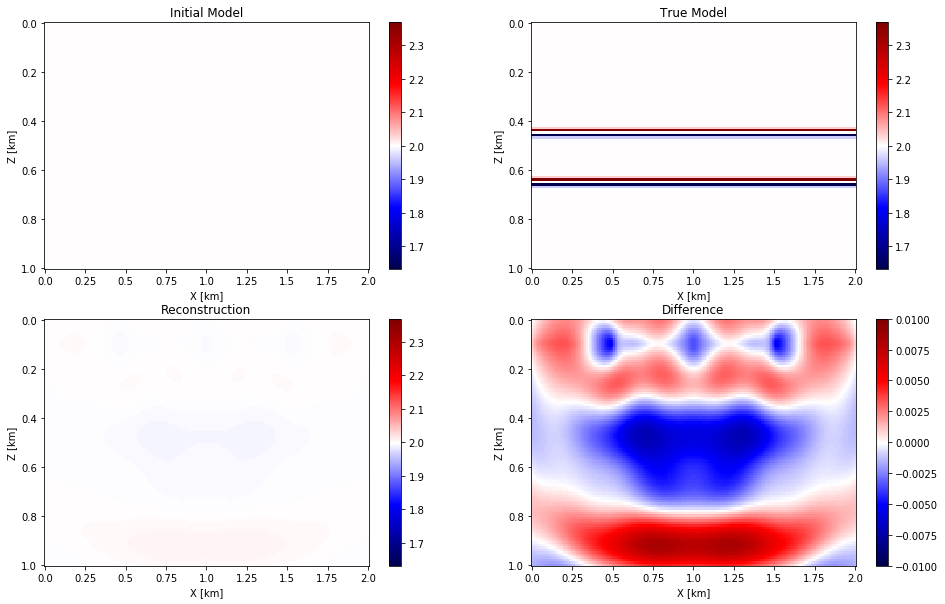

In [31]:
    obj_vals = np.array([v for k,v in list(invalg.objective_history.items())])

    plt.figure()
    plt.semilogy(obj_vals)
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
    
    clim = C.min(),C.max()

    # Do something to visualize the results
    plt.figure(figsize=(16,10))
    plt.subplot(2,2,1)
    vis.plot(C0, m, clim=clim)
    plt.title('Initial Model')
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.colorbar()
    plt.subplot(2,2,2)
    vis.plot(C, m, clim=clim)
    plt.title('True Model')
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.colorbar()
    plt.subplot(2,2,3)
    vis.plot(result.C, m, clim=clim)
    plt.title('Reconstruction')
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.colorbar()
    plt.subplot(2,2,4)
    vis.plot(result.C-C0, m, clim=[-.01,.01])
    plt.title('Difference')
    plt.xlabel('X [km]')
    plt.ylabel('Z [km]')
    plt.colorbar()

    plt.show()